In [40]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
sys.path.append('../../Code/')
from testWN import testWN as twm
from wntr.metrics import economic

In [2]:
%matplotlib notebook

# Get Network Information

In [3]:
inp_file = '../../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)

nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())
node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Load Result File

In [63]:
with open('./tempResults/02_results_sim_time.pkl', 'rb') as f:
    results = pickle.load(f)

In [65]:
with open('/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/results_sim_0_noControls.pkl', 'rb') as f:
    ref = pickle.load(f)

# Pressure

<IPython.core.display.Javascript object>


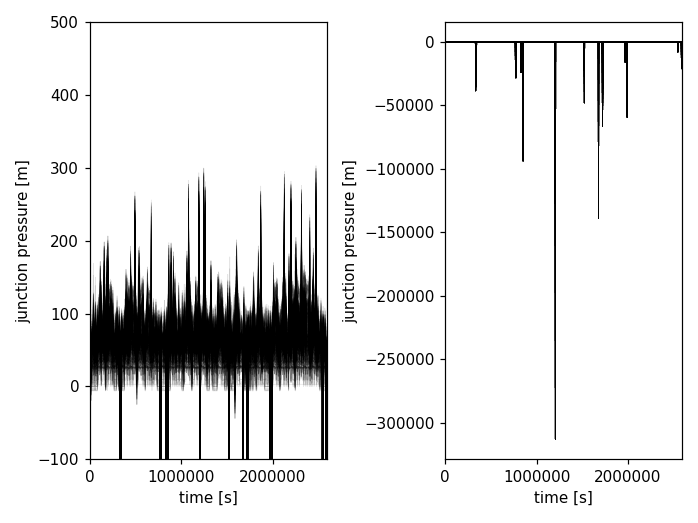

In [66]:
fig, ax = plt.subplots(1,2)
results.node['pressure'][node_names[2]].plot(legend=False, ax=ax[0], color='k', linewidth=0.5, alpha=0.1)
ax[0].set_ylim(-100,500)
results.node['pressure'][node_names[2]].plot(legend=False, ax=ax[1], color='k', linewidth=0.5, alpha=0.1)

ax[0].set_xlabel('time [s]')
ax[1].set_xlabel('time [s]')

ax[0].set_ylabel('junction pressure [m]')
ax[1].set_ylabel('junction pressure [m]')

fig.tight_layout()

## Tank Levels

In [94]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize = (9,4))
results.node['pressure'][node_names[0]].plot(legend=False, ax=ax[0])
ref.node['pressure'][node_names[0]].plot(legend=True, ax=ax[1])

ax[0].set_ylabel('tank level [m]')
ax[0].set_xlabel('time [s]')
ax[1].set_xlabel('time [s]')

ax[0].set_title('MPC')
ax[1].set_title('Rule-based control')


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Rule-based control')

# Energy

<IPython.core.display.Javascript object>


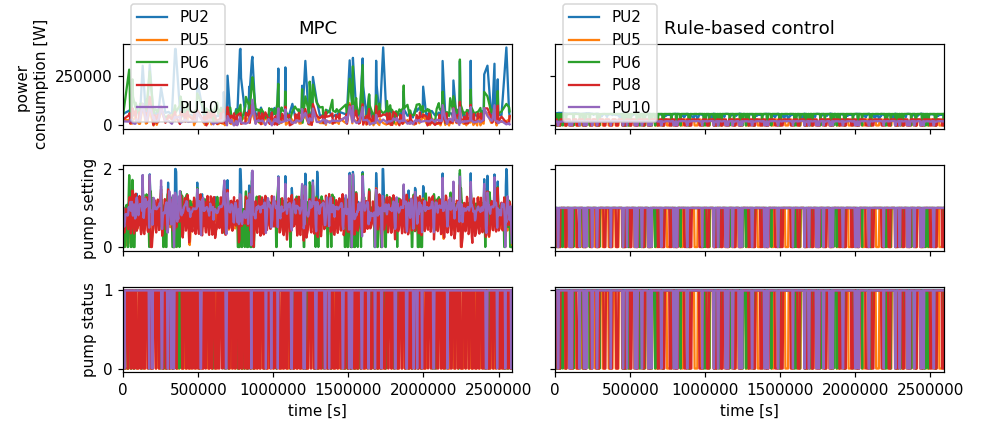

In [97]:
pump_power_mpc = economic.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_power_mpc = pump_power_mpc[(pump_power_mpc>0).all(axis=1)]

pump_power_rb = economic.pump_energy(ref.link['flowrate'], ref.node['head'], ctown.wn)[link_names[0]]
pump_power_rb = pump_power_rb[(pump_power_rb>=0).all(axis=1)]

fig, ax = plt.subplots(3,2, sharey='row', sharex=True, figsize = (9,4))
pump_power_mpc.plot(ax=ax[0,0])
pump_power_rb.plot(ax=ax[0,1])

results.link['setting'][link_names[0]].plot(ax=ax[1,0], legend=False)
ref.link['setting'][link_names[0]].plot(ax=ax[1,1], legend=False)

results.link['status'][link_names[0]].plot(ax=ax[2,0], legend=False)
ref.link['status'][link_names[0]].plot(ax=ax[2,1], legend=False)


ax[0,0].set_ylabel('power \n consumption [W]')
ax[1,0].set_ylabel('pump setting')
ax[2,0].set_ylabel('pump status')


ax[-1,0].set_xlabel('time [s]')
ax[-1,1].set_xlabel('time [s]')

ax[0,0].set_title('MPC')
ax[0,1].set_title('Rule-based control')

fig.tight_layout()

In [89]:
energy_mpc = np.sum(np.trapz(pump_power_mpc.to_numpy().T/1e3, dx=1))
energy_rb = np.sum(np.trapz(pump_power_rb.to_numpy().T/1e3, dx=1))

perc_diff = 100*(energy_rb-energy_mpc)/energy_rb

print('MPC power consumption:        {:.2f} kWh'.format(energy_mpc))
print('Rule-based power consumption: {:.2f} kWh'.format(energy_rb))
print('Power reduction: {:.2f}%'.format(perc_diff))

MPC power consumption:        72824.61 kWh
Rule-based power consumption: 109732.48 kWh
Power reduction: 33.63%
